In [24]:
#Libraries
library(leaps)
library(glmnet)
library(tidymodels)

# Linear Methods

In this notebook, we explore linear methods: simple linear regression and regsubset

## 1. Data preparation

In [1]:
train <- read.csv(file = '../../Data/training_data.csv')
test <-  read.csv(file = '../../Data/test_data.csv')
train.regr <- train[,-3]
train.regr <- na.omit(train.regr)

#Declaring a function to remove predictors with 0 variance. This function returns the indices of the predicors with 0 variance.
ZeroVar <- function(data) {
    out <- lapply(data, function(x) length(unique(x)))
    want <- which(!out > 1)
    unlist(want)
}

#Applying the ZeroVar function
train.zeroVar <- train.regr[,-ZeroVar(train.regr)]

## 2. Basic linear fit

In [ ]:
linear.fit1 <- lm(VALENCE.PLEASANTNESS ~ .,train.regr)
linear.fit2 <- lm(VALENCE.PLEASANTNESS ~ .,train.zeroVar)
#summary(linear.fit1)
#summary(linear.fit2)

We do not show the entire results for these fits as it unnecessarily polluts this file, the respective $adusted-R^2$ values are:
- 0.3205 for linear.fit1
- 0.532 for linear.fit2

## 3. Subset Selection
### Foward selection

In [33]:
less_variable.study.fw <- regsubsets(VALENCE.PLEASANTNESS ~ ., train.regr,nvmax = 150,really.big=T,method="forward")

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"4538  linear dependencies found"

Reordering variables and trying again:


In [10]:
#summary(less_variable.study)
#Printing the 10 most influent variables
coef(less_variable.study.fw,id = 10) 

(Intercept)        MATS6i          JGI6    P_VSA_MR_2  Eig05_EA.dm. 
   43.9192931    13.4428892   359.2610360     0.1407271     8.9144291 
      RDF120m        HATS5v         nRNHR  CATS2D_03_NL      F01.C.S. 
  -12.2158196   -63.6578172   -24.2947635   -13.4447988    -6.6393971 
Depressant.50 
  -37.4410701

We do the same again with the data that has no zero variance predictors

In [19]:
less_variable.study.fw2 <- regsubsets(VALENCE.PLEASANTNESS ~ ., train.zeroVar,nvmax = 500,really.big=T,method="forward")
coef(less_variable.study.fw2,id = 10)                   


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2696  linear dependencies found"

Reordering variables and trying again:


Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
"number of items to replace is not a multiple of replacement length"

(Intercept)        MATS6i          JGI6    P_VSA_MR_2  Eig05_EA.dm. 
   43.9192931    13.4428892   359.2610360     0.1407271     8.9144291 
      RDF120m        HATS5v         nRNHR  CATS2D_03_NL      F01.C.S. 
  -12.2158196   -63.6578172   -24.2947635   -13.4447988    -6.6393971 
Depressant.50 
  -37.4410701

### Backward Selection

it was finally too long to run

In [ ]:
#do not run (too long)
less_variable.study.bc <- regsubsets(VALENCE.PLEASANTNESS ~ ., train.regr,nvmax = 100,really.big=T,method="backward")


In [34]:
C <- coef(less_variable.study.fw,id = 150) 


In [13]:
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}

In [35]:
Id.best.variables <- names(C)
Id.best.variables <- Id.best.variables[-1]

In [20]:
Id.process <- names(coef(less_variable.study.fw2,id = 325))[-1]

## K fold Validation (for subset selection) 

In [25]:
#keep only the 100 most important variables.
m <- model.matrix(VALENCE.PLEASANTNESS ~ .,train.regr)
data.for.validation <- m[,Id.best.variables]
data.for.validation <- data.frame(data.for.validation)
data.for.validation$VALENCE.PLEASANTNESS <- train.regr[,"VALENCE.PLEASANTNESS"]
dim(data.for.validation)

[1] 708 101

In [41]:
validation_data <- vfold_cv(data.for.validation, v = 10) #v = nbr of fold !

fit_and_evaluate <- function(fold, formula) {
    best.fit.id <- regsubsets(formula, analysis(fold),really.big=T,method="forward",nvmax = 150)
    valid.set <- assessment(fold)
    sapply(seq(1, best.fit.id$nvmax - 1), function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict.regsubsets(best.fit.id, valid.set, id, formula))^2))
}
v.errors <- sapply(validation_data$splits, fit_and_evaluate,VALENCE.PLEASANTNESS ~ .)
v.errors.id <- rowMeans(v.errors)

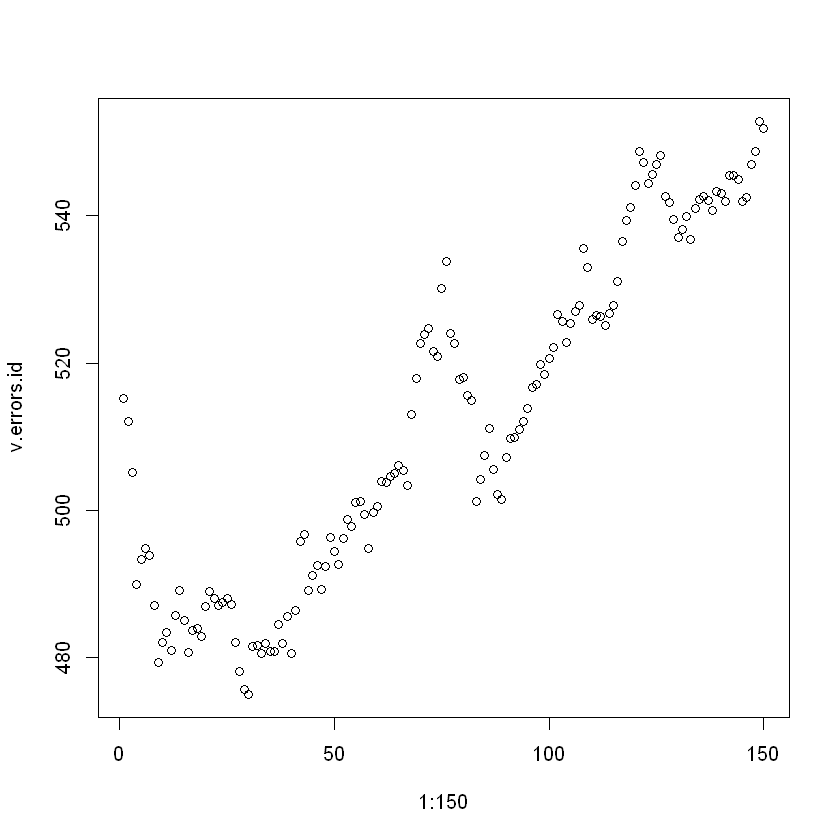

In [42]:
plot(1:150,v.errors.id)

Based on this graph we should do regression with only 30 variables. 

In [31]:
m <- model.matrix(VALENCE.PLEASANTNESS ~ .,train.zeroVar)
data.for.validation <- m[,Id.process]
data.for.validation <- data.frame(data.for.validation)
data.for.validation$VALENCE.PLEASANTNESS <- train.regr[,"VALENCE.PLEASANTNESS"]

fit_and_evaluate <- function(fold, formula) {
    best.fit.id <- regsubsets(formula, analysis(fold),really.big=T,method="forward",nvmax = 300)
    valid.set <- assessment(fold)
    sapply(seq(1, best.fit.id$nvmax - 1), function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict.regsubsets(best.fit.id, valid.set, id, formula))^2))
}

validation_data <- vfold_cv(data.for.validation, v = 12) #v = nbr of fold !

v.errors <- sapply(validation_data$splits, fit_and_evaluate,VALENCE.PLEASANTNESS ~ .)
v.errors.id <- rowMeans(v.errors)

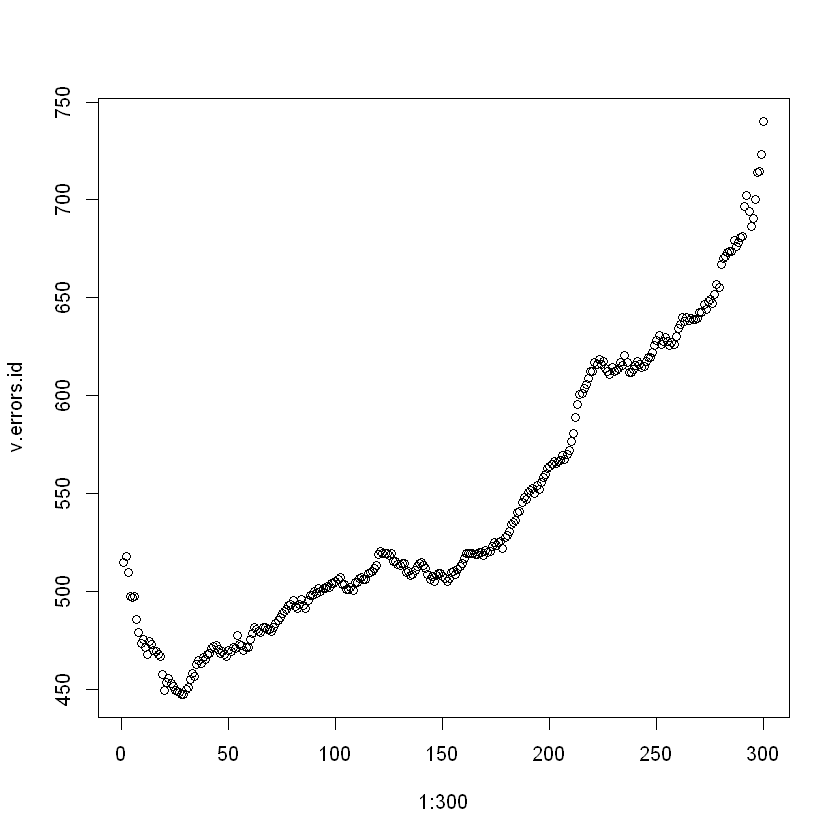

In [32]:
plot(1:300,v.errors.id)

Here the optimum choice is also with about 30 variables.